In [68]:
import ee
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as rio
from rasterio.plot import show

from src.data import mtbs
from src.visualization import ee_viz
from src.visualization.gedi_viz import geo_plot
from src.visualization import gedi_viz
from src.data import gedi_loader
from src.data import fire_perimeters
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB


import seaborn as sns
sns.set_theme()

import importlib
importlib.reload(mtbs)
importlib.reload(ee_viz)
importlib.reload(fire_perimeters)
importlib.reload(gedi_loader)
importlib.reload(gedi_viz)

<module 'src.visualization.gedi_viz' from '/home/jk871/fire-regen/src/visualization/gedi_viz.py'>

### Get North Complex Fire Info

Creek fire is the second largest Sierra fire from the years 2020/2021, and we have GEDI data for both before and after the fire.

In [2]:
sierras = gpd.read_file("../../../data/shapefiles/sierras_convex_hull.shp")

firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2020', '2021']).filter_within_geometry(sierras)

fire = sierra_firep.get_fire('NORTH COMPLEX')

In [3]:
raster_file_path = "/maps/fire-regen/data/rasters/NORTH_COMPLEX/"

In [5]:
raster_db = FireRastersDB(raster_file_path, 'north_complex')

## Visualize Location and Perimeter

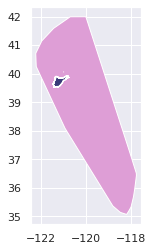

In [6]:
fire.overlay_fire_map(sierras)

In [7]:
fire.get().geometry.explore()

### Get fire GEDI shots and match them to NBR rasters

In [8]:
fire.load_gedi(load_buffer=True)

2023-05-06 22:58:56,330 INFO: Loading Level 4a GEDI shots for period 2019-2023 in this geometry [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:20]
2023-05-06 22:59:15,550 INFO: Number of GEDI shots found: 122612 [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:58]
2023-05-06 22:59:15,606 INFO: Loading Level 4a GEDI shots for period 2019-2023 in this geometry [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:20]
2023-05-06 22:59:52,091 INFO: Number of GEDI shots found: 259730 [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:58]


### Get CREEK severity rasters

In [9]:
def before_fire(shots):
    return shots[shots.absolute_time < fire.alarm_date]

def after_fire(shots):
    return shots[shots.absolute_time > fire.cont_date]

def filter_trees(shots):
    return shots[shots.pft_class == 1]

In [10]:
gedi_dnbr6 = match_gedi_to_raster(fire.gedi, raster_db.get('dnbr6'), 3, ['severity'])
gedi_dnbr = match_gedi_to_raster(fire.gedi, raster_db.get('dnbr'), 3, ['severity'])
gedi_rdnbr = match_gedi_to_raster(fire.gedi, raster_db.get('rdnbr'), 3, ['severity'])

In [11]:
gedi_buffer_dnbr6 = match_gedi_to_raster(fire.gedi_buffer, raster_db.get('dnbr6'), 3, ['severity'])
gedi_buffer_dnbr = match_gedi_to_raster(fire.gedi_buffer, raster_db.get('dnbr'), 3, ['severity'])
gedi_buffer_rdnbr = match_gedi_to_raster(fire.gedi_buffer, raster_db.get('rdnbr'), 3, ['severity'])

<AxesSubplot: xlabel='severity_median', ylabel='Count'>

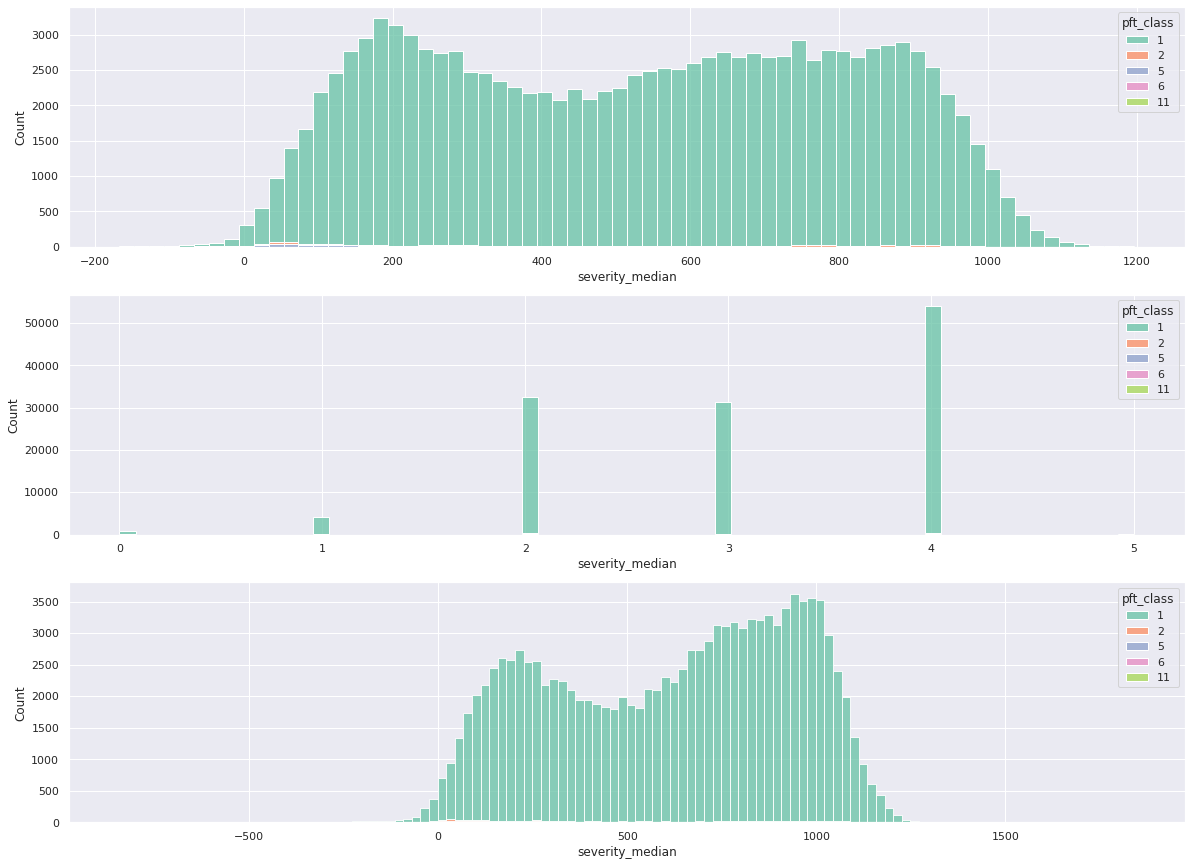

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(20,15))
sns.histplot(gedi_dnbr, x='severity_median', ax=ax[0], hue='pft_class', multiple='stack', palette='Set2')
sns.histplot(gedi_dnbr6, x='severity_median', ax=ax[1], hue='pft_class', multiple='stack', palette='Set2')
sns.histplot(gedi_rdnbr, x='severity_median', ax=ax[2], hue='pft_class', multiple='stack', palette='Set2')

(0.0, 1000.0)

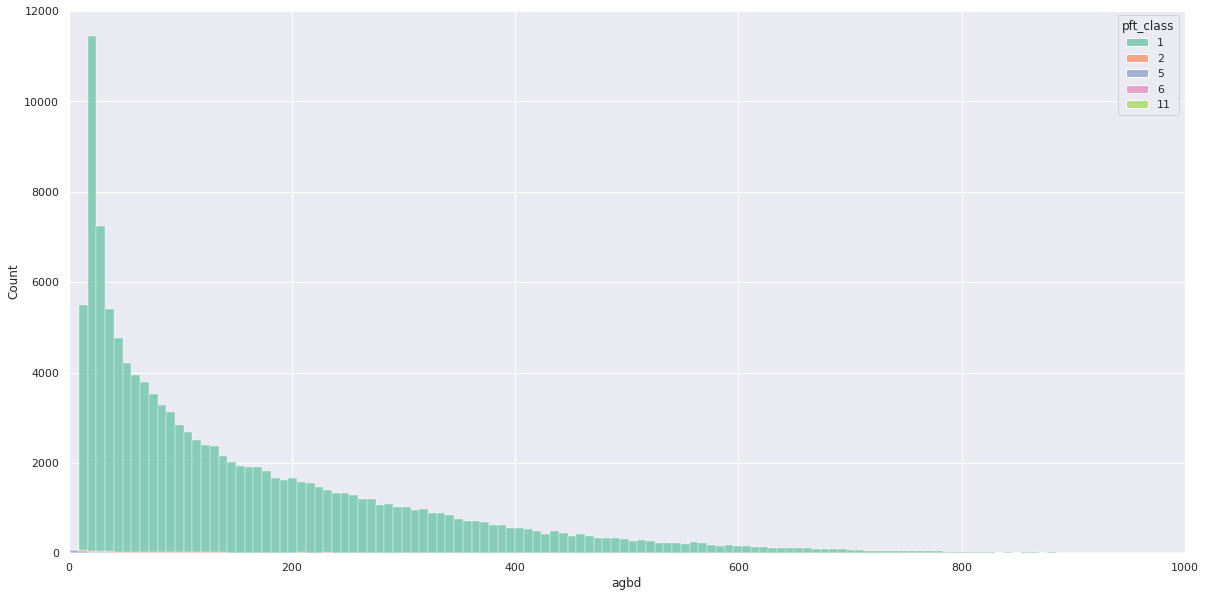

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
sns.histplot(gedi_dnbr, x='agbd', ax=ax, hue='pft_class', multiple='stack', palette='Set2')
ax.set_xlim((0, 1000))

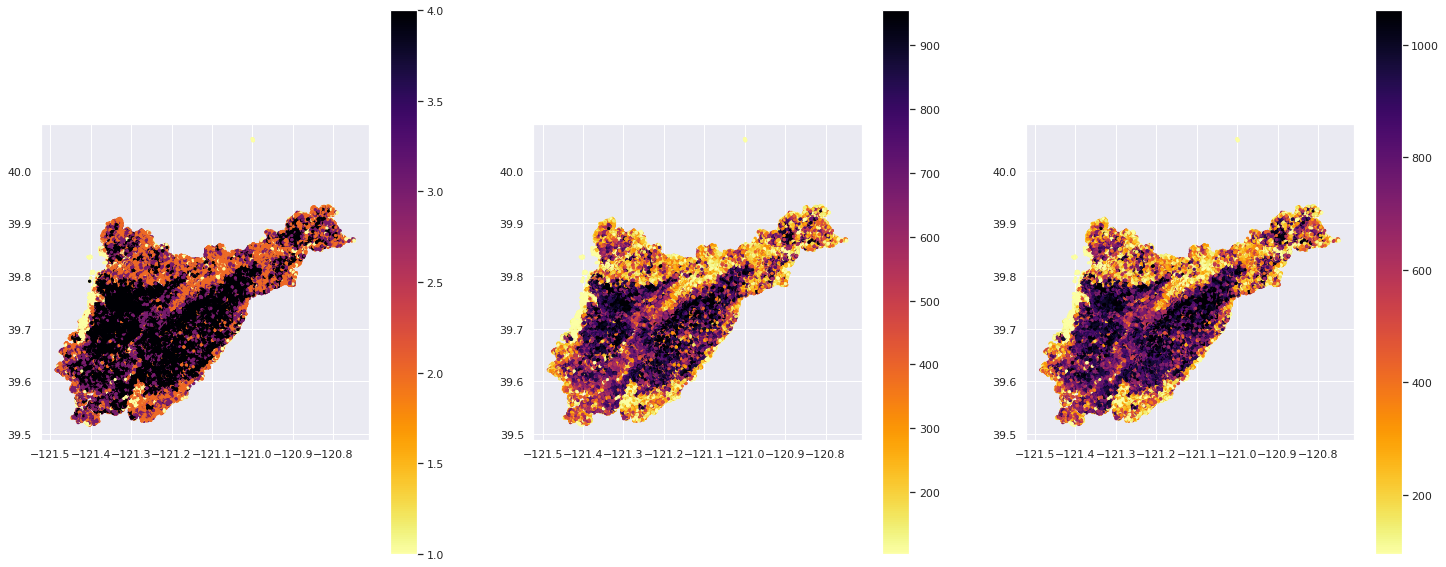

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(25,10))

geo_plot(gedi_dnbr6, ax[0], 'severity_median', vmin=1, vmax=4)
geo_plot(gedi_dnbr, ax[1], 'severity_mean')
geo_plot(gedi_rdnbr, ax[2], 'severity_mean')

### Look at GEDI outliers - i.e. high values

In [21]:
gedi_dnbr[gedi_dnbr.agbd > 1000]

shot_number                     absolute_time  lon_lowestmode  \
2872     50840800200218170  2019-11-05 09:15:45.128781+00:00     -121.284051   
7080     43860600300520542  2019-09-21 10:38:03.961735+01:00     -121.355726   
11702    50840600200323904  2019-11-05 09:15:45.227973+00:00     -121.260368   
13103    33481100300281977  2019-07-16 13:08:36.746856+01:00     -121.273870   
13230   218500800300189615  2022-10-21 20:54:35.433997+01:00     -120.790860   
...                    ...                               ...             ...   
190082   33480200300283455  2019-07-16 13:08:39.775779+01:00     -121.139839   
194896  137621100200214192  2021-05-18 04:49:28.874644+01:00     -121.365691   
210803   43861100300282130  2019-09-21 10:38:07.697261+01:00     -121.147743   
217442   43861100300281969  2019-09-21 10:38:06.366670+01:00     -121.231911   
217960   43860600300520804  2019-09-21 10:38:06.127014+01:00     -121.218574   

        lat_lowestmode         agbd  agbd_pi_lower  agbd_pi_upper    agbd_se  \
2872         39.756550  1031.585815     707.899902    1416.034058  11.218775   
7080         39.754746  1336.971191     963.871399    1770.975098  11.244919   
11702        39.779028  1019.609619     698.194763    1401.699707  11.202627   
13103        39.768590  1099.288208     764.184082    1495.148560  11.217625   
13230        39.862079  1031.562256     708.069458    1415.739380  11.204320   
...                ...          ...            ...            ...        ...   
190082       39.654601  2354.235352    1845.666870    2924.614014  11.412226   
194896       39.849421  1017.394104     696.427185    1399.008667  11.197572   
210803       39.611953  1178.571411     830.096436    1587.963989  11.247350   
217442       39.663185  1199.388672     847.688416    1611.965332  11.239871   
217960       39.671523  1003.920044     685.285645    1383.202637  11.197683   

       beam_type  sensitivity  pft_class                     geometry  \
2872        full     0.965529          1  POINT (-121.28405 39.75655)   
7080        full     0.989315          1  POINT (-121.35573 39.75475)   
11702       full     0.968657          1  POINT (-121.26037 39.77903)   
13103       full     0.978676          1  POINT (-121.27387 39.76859)   
13230       full     0.982744          1  POINT (-120.79086 39.86208)   
...          ...          ...        ...                          ...   
190082  coverage     0.952373          1  POINT (-121.13984 39.65460)   
194896      full     0.982889          1  POINT (-121.36569 39.84942)   
210803      full     0.988581          1  POINT (-121.14774 39.61195)   
217442      full     0.979962          1  POINT (-121.23191 39.66319)   
217960      full     0.986704          1  POINT (-121.21857 39.67152)   

                                         severity_3x3  severity_sample  \
2872    [932, 951, 961, 956, 924, 907, 912, 895, 930]              924   
7080    [862, 789, 752, 762, 789, 838, 779, 755, 732]              789   
11702   [340, 498, 451, 530, 518, 644, 549, 541, 494]              518   
13103   [691, 756, 630, 784, 748, 704, 891, 802, 719]              748   
13230   [184, 178, 205, 122, 239, 272, 134, 154, 299]              239   
...                                               ...              ...   
190082  [901, 913, 961, 901, 808, 811, 858, 383, 405]              808   
194896    [341, 357, 55, 226, 172, 92, 226, 249, 191]              172   
210803  [439, 501, 762, 563, 721, 785, 728, 798, 730]              721   
217442  [862, 880, 850, 923, 924, 850, 923, 899, 926]              924   
217960  [336, 837, 963, 850, 634, 816, 887, 931, 905]              634   

        severity_mean  severity_std  severity_median  
2872       929.777778     21.591036            930.0  
7080       784.222222     39.619798            779.0  
11702      507.222222     77.182004            518.0  
13103      747.222222     70.450578            748.0  
13230      198.555556     57.550193            184.0

<AxesSubplot: >

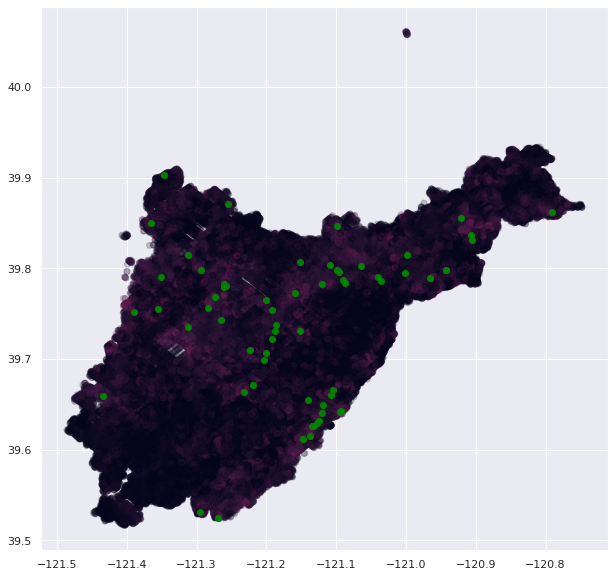

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

gedi_dnbr.plot(column='agbd', ax=ax, alpha=0.2)
gedi_dnbr[gedi_dnbr.agbd > 1000].plot(column='agbd', ax=ax, color='green')

### Look at GEDI before and after fire

In [25]:
print('AGBD before fire')
print(fire.get_gedi_before_fire().agbd.describe())

print('AGBD after fire')
print(fire.get_gedi_after_fire().agbd.describe())

AGBD before fire
count    43182.000000
mean       218.015248
std        166.431037
min          2.438513
25%         86.163866
50%        182.494102
75%        307.584953
max       2354.235352
Name: agbd, dtype: float64
AGBD after fire
count    76901.000000
mean       131.403766
std        142.744261
min          1.437881
25%         30.549917
50%         76.934067
75%        179.065628
max       1294.420410
Name: agbd, dtype: float64


(0.0, 700.0)

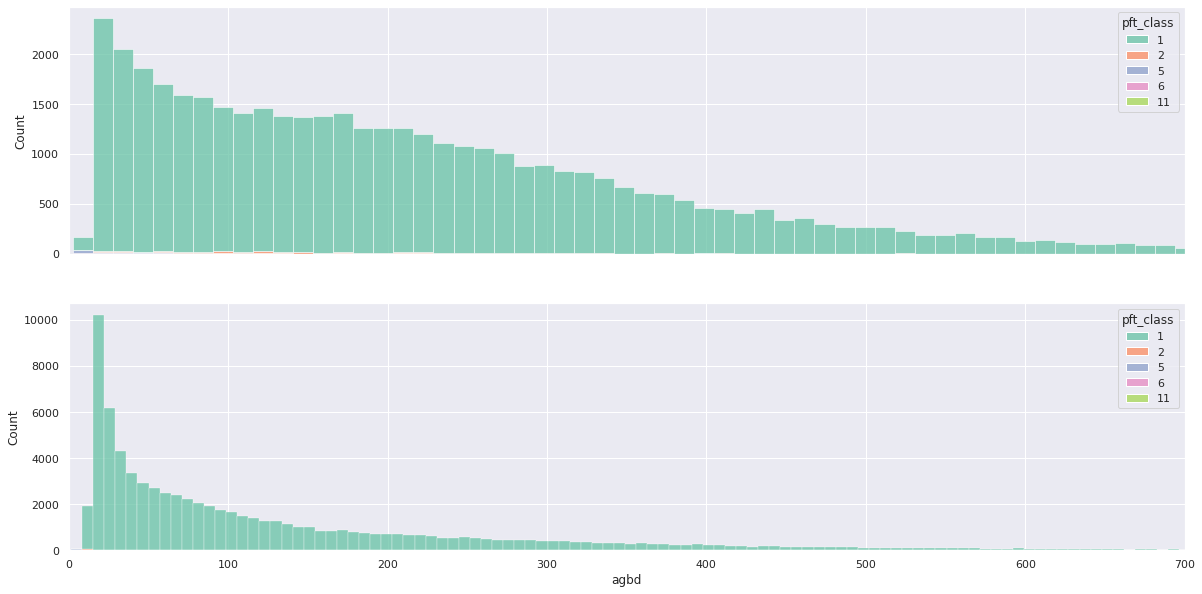

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(before_fire(gedi_dnbr), x='agbd', ax=ax[0], hue='pft_class', multiple='stack', palette='Set2')
g = sns.histplot(after_fire(gedi_dnbr), x='agbd', ax=ax[1], hue='pft_class', multiple='stack', palette='Set2')
ax[1].set_xlim((0, 700))

(0.0, 700.0)

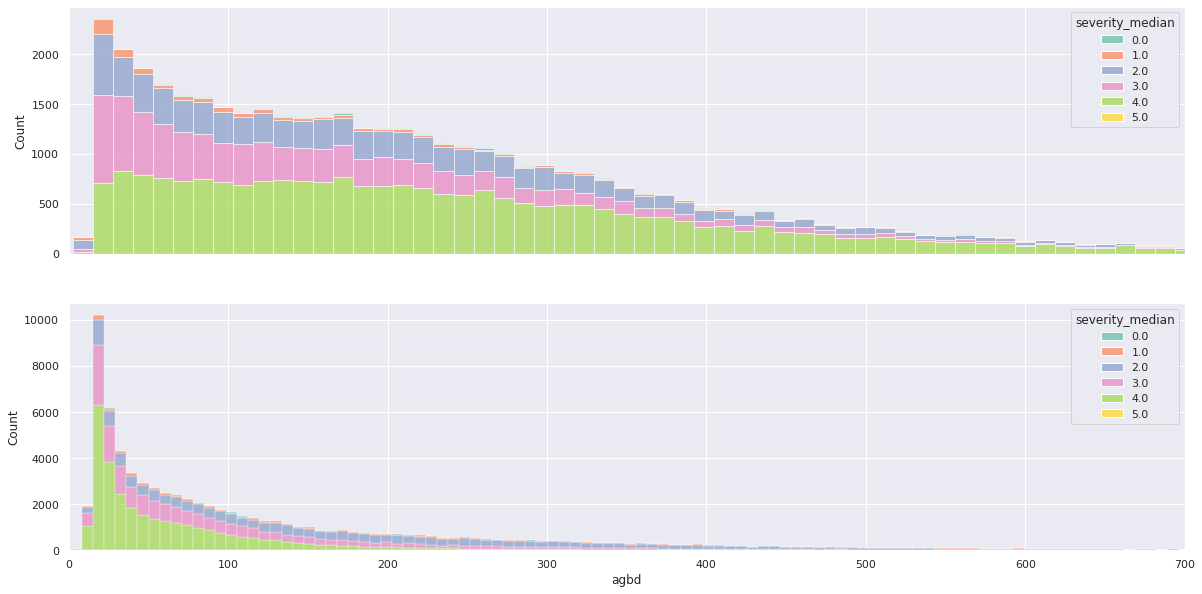

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(before_fire(gedi_dnbr6), x='agbd', ax=ax[0], hue='severity_median', multiple='stack', palette='Set2')
g = sns.histplot(after_fire(gedi_dnbr6), x='agbd', ax=ax[1], hue='severity_median', multiple='stack', palette='Set2')
ax[1].set_xlim((0, 700))

<AxesSubplot: xlabel='agbd', ylabel='severity_median'>

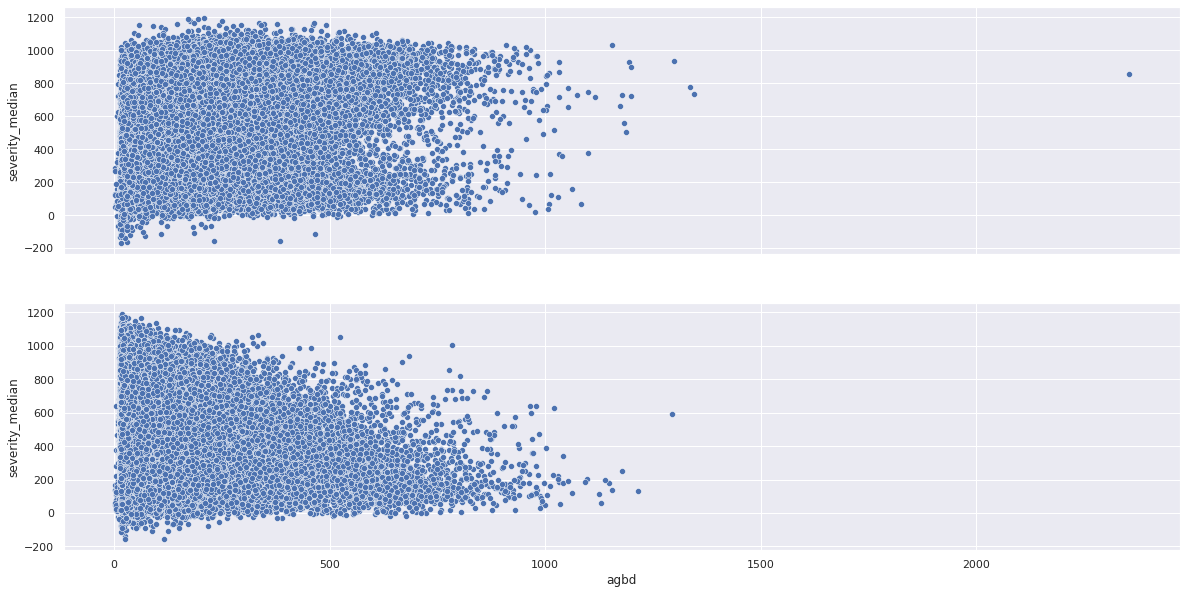

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.scatterplot(before_fire(gedi_dnbr), x='agbd', y='severity_median', ax=ax[0])
sns.scatterplot(after_fire(gedi_dnbr), x='agbd', y='severity_median', ax=ax[1])

<AxesSubplot: xlabel='agbd', ylabel='severity_median'>

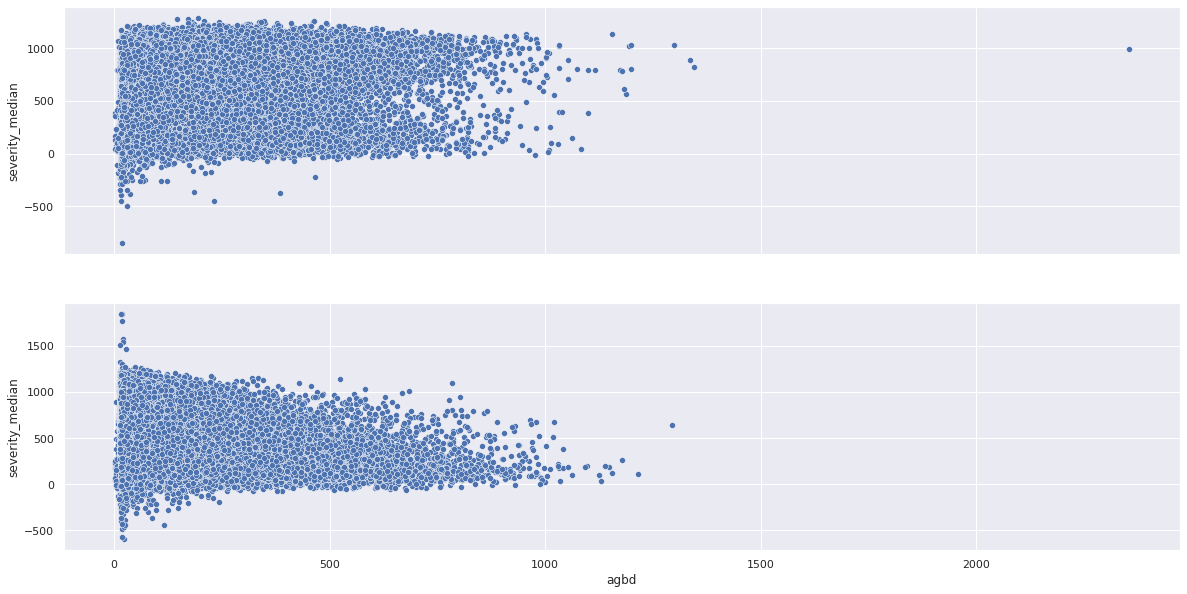

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.scatterplot(before_fire(gedi_rdnbr), x='agbd', y='severity_median', ax=ax[0])
sns.scatterplot(after_fire(gedi_rdnbr), x='agbd', y='severity_median', ax=ax[1])

<AxesSubplot: xlabel='agbd', ylabel='severity_median'>

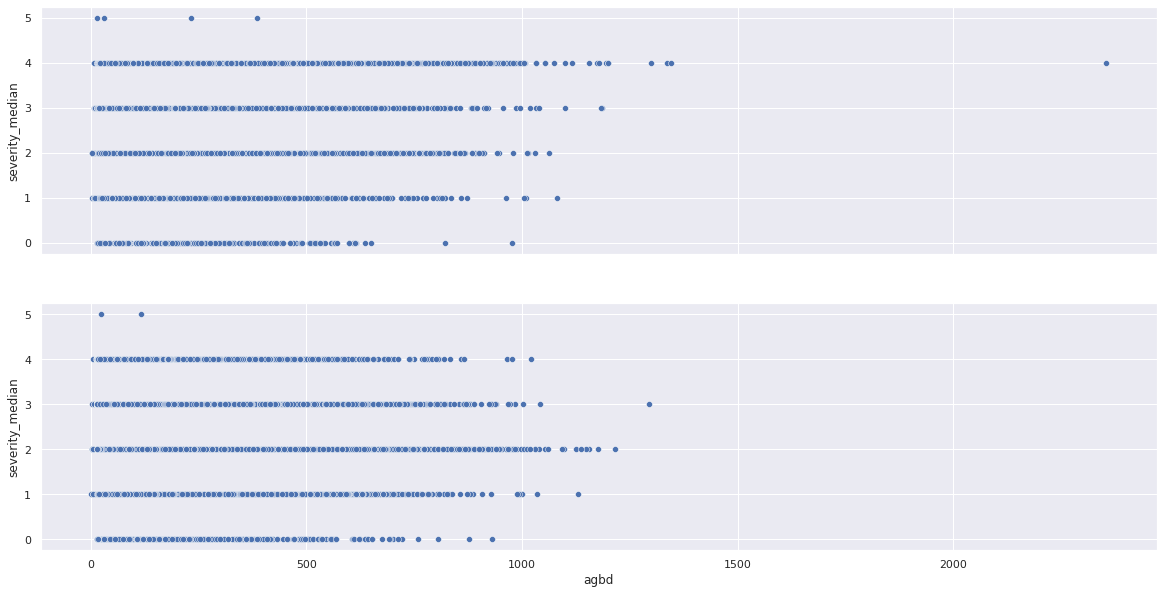

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.scatterplot(before_fire(gedi_dnbr6), x='agbd', y='severity_median', ax=ax[0])
sns.scatterplot(after_fire(gedi_dnbr6), x='agbd', y='severity_median', ax=ax[1])

<AxesSubplot: xlabel='severity_median', ylabel='Count'>

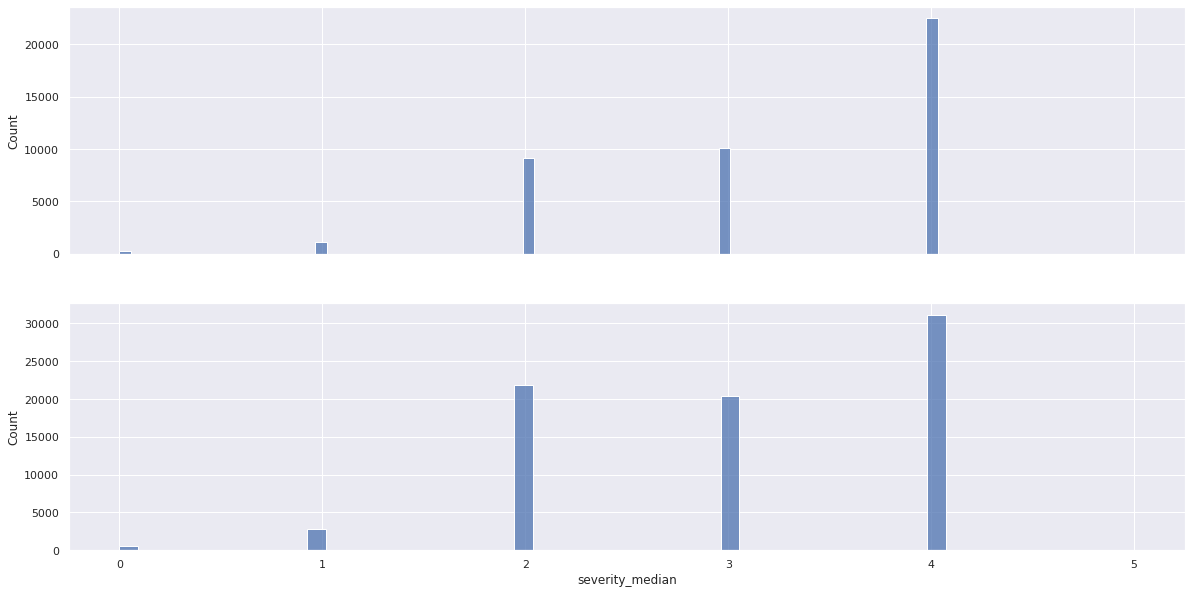

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(before_fire(gedi_dnbr6), x='severity_median', ax=ax[0])
sns.histplot(after_fire(gedi_dnbr6), x='severity_median', ax=ax[1])

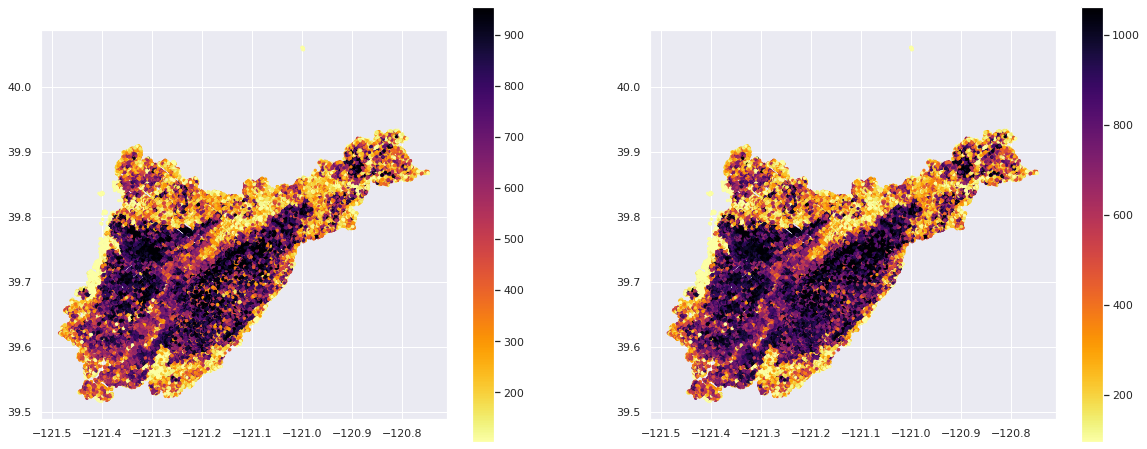

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

geo_plot(gedi_dnbr, ax[0], 'severity_mean')
geo_plot(gedi_rdnbr, ax[1], 'severity_mean')

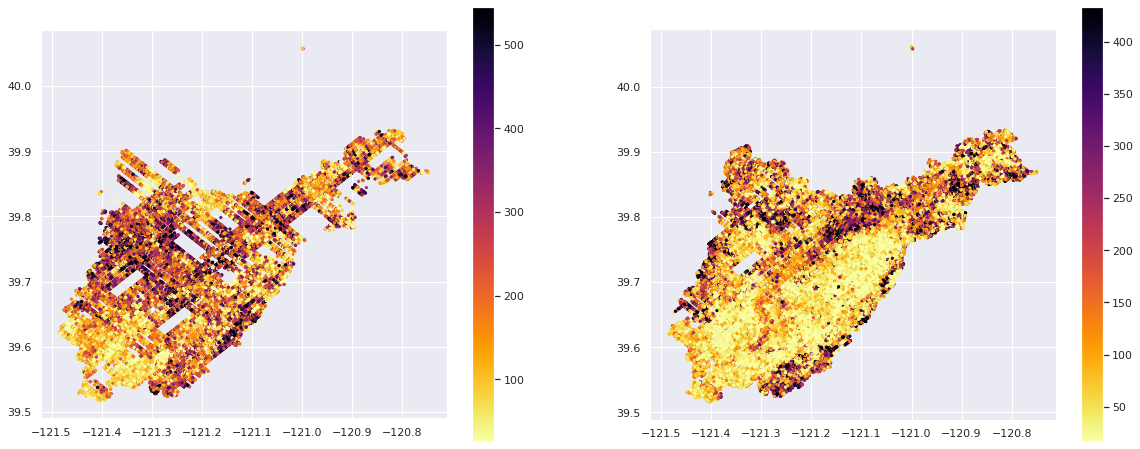

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

geo_plot(before_fire(gedi_dnbr), ax[0], 'agbd')
geo_plot(after_fire(gedi_dnbr), ax[1, 'agbd'])

In [60]:
# Divide unburned after into two segments
gedi_after = after_fire(fire.gedi)
gedi_after.absolute_time = pd.to_datetime(gedi_after.absolute_time, utc=True)
gedi_after_1 = gedi_after[gedi_after.absolute_time < '01-01-2022']
gedi_after_2 = gedi_after[gedi_after.absolute_time > '01-01-2022']

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


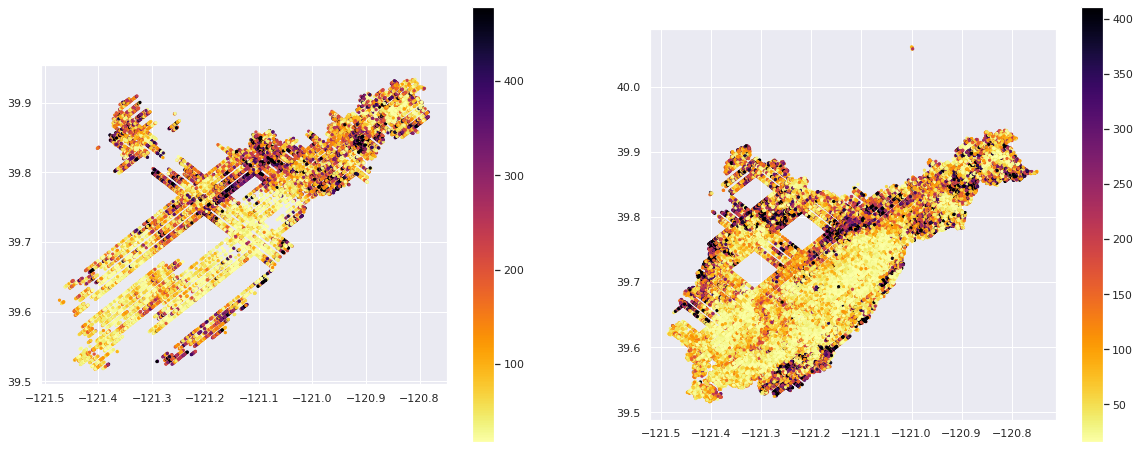

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

geo_plot(gedi_after_1, ax[0], 'agbd')
geo_plot(gedi_after_2, ax[1], 'agbd')

### Look at unburned buffer zone GEDI before and after fire

In [37]:
unburned_before = before_fire(gedi_buffer_dnbr6)
unburned_after = after_fire(gedi_buffer_dnbr6)
print('AGBD before fire')
print(unburned_before.agbd.describe())

print('AGBD after fire')
print(unburned_after.agbd.describe())

AGBD before fire
count    86346.000000
mean       167.477330
std        147.966149
min          0.742466
25%         54.117949
50%        124.737701
75%        235.770424
max       1317.793213
Name: agbd, dtype: float64
AGBD after fire
count    155363.000000
mean        154.486485
std         142.902844
min           0.834731
25%          47.094952
50%         108.957680
75%         216.829453
max        3538.607178
Name: agbd, dtype: float64


In [38]:
unburned_before = before_fire(gedi_buffer_dnbr6[(gedi_buffer_dnbr6.severity_median == 0) & (gedi_buffer_dnbr6.severity_std == 0)])
unburned_after = after_fire(gedi_buffer_dnbr6[(gedi_buffer_dnbr6.severity_median == 0) & (gedi_buffer_dnbr6.severity_std == 0)])
print('AGBD before fire')
print(unburned_before.agbd.describe())

print('AGBD after fire')
print(unburned_after.agbd.describe())

AGBD before fire
count    85509.000000
mean       167.643517
std        148.039527
min          0.742466
25%         54.167000
50%        124.929626
75%        236.023773
max       1317.793213
Name: agbd, dtype: float64
AGBD after fire
count    153672.000000
mean        154.503869
std         142.921284
min           0.834731
25%          47.111989
50%         108.978107
75%         216.815548
max        3538.607178
Name: agbd, dtype: float64


In [39]:
print('AGBD before fire')
print(unburned_before[unburned_before.pft_class==1].agbd.describe())

print('AGBD after fire')
print(unburned_after[unburned_after.pft_class==1].agbd.describe())

AGBD before fire
count    83450.000000
mean       170.053047
std        148.066622
min         12.475229
25%         56.472178
50%        127.389477
75%        238.514812
max       1317.793213
Name: agbd, dtype: float64
AGBD after fire
count    150540.000000
mean        156.233919
std         143.127900
min          10.458276
25%          48.552589
50%         110.778194
75%         218.794220
max        3538.607178
Name: agbd, dtype: float64


(0.0, 700.0)

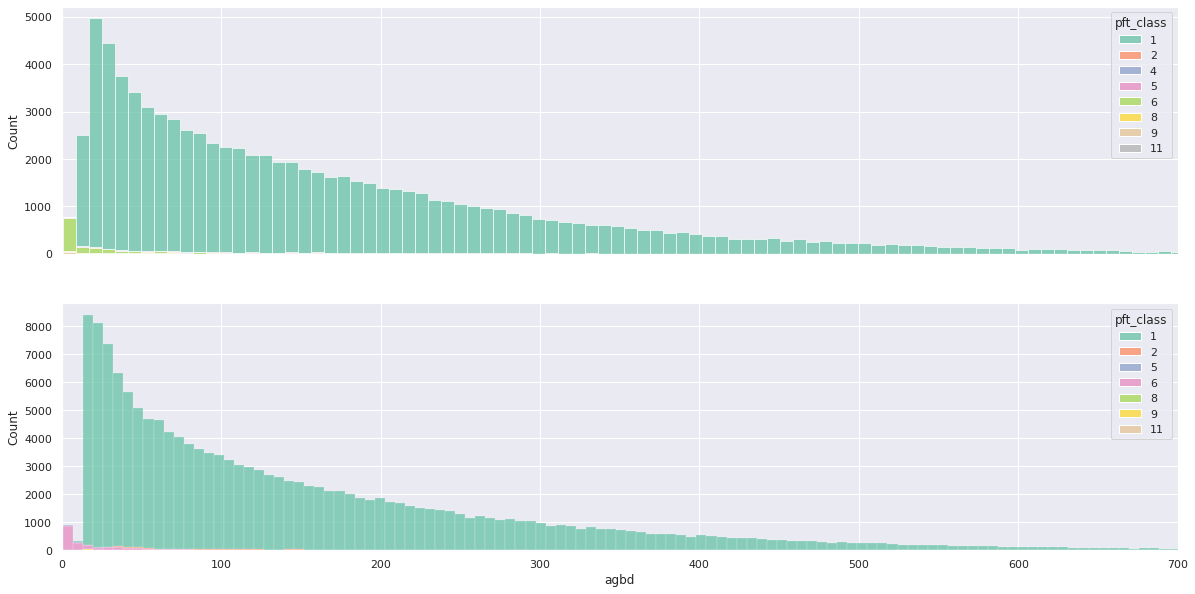

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(before_fire(gedi_buffer_dnbr), x='agbd', ax=ax[0], hue='pft_class', multiple='stack', palette='Set2')
g = sns.histplot(after_fire(gedi_buffer_dnbr), x='agbd', ax=ax[1], hue='pft_class', multiple='stack', palette='Set2')
ax[1].set_xlim((0, 700))

<AxesSubplot: xlabel='agbd', ylabel='severity_median'>

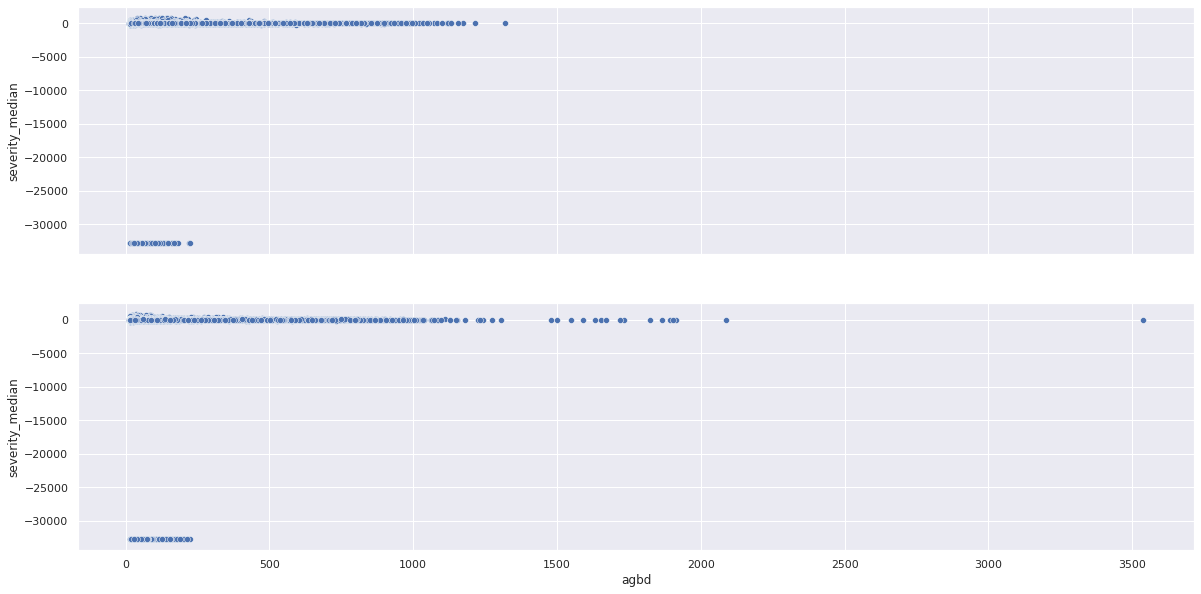

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.scatterplot(before_fire(gedi_buffer_dnbr)[before_fire(gedi_buffer_dnbr).pft_class==1], x='agbd', y='severity_median', ax=ax[0])
sns.scatterplot(after_fire(gedi_buffer_dnbr)[after_fire(gedi_buffer_dnbr).pft_class==1], x='agbd', y='severity_median', ax=ax[1])

<AxesSubplot: xlabel='severity_median', ylabel='Count'>

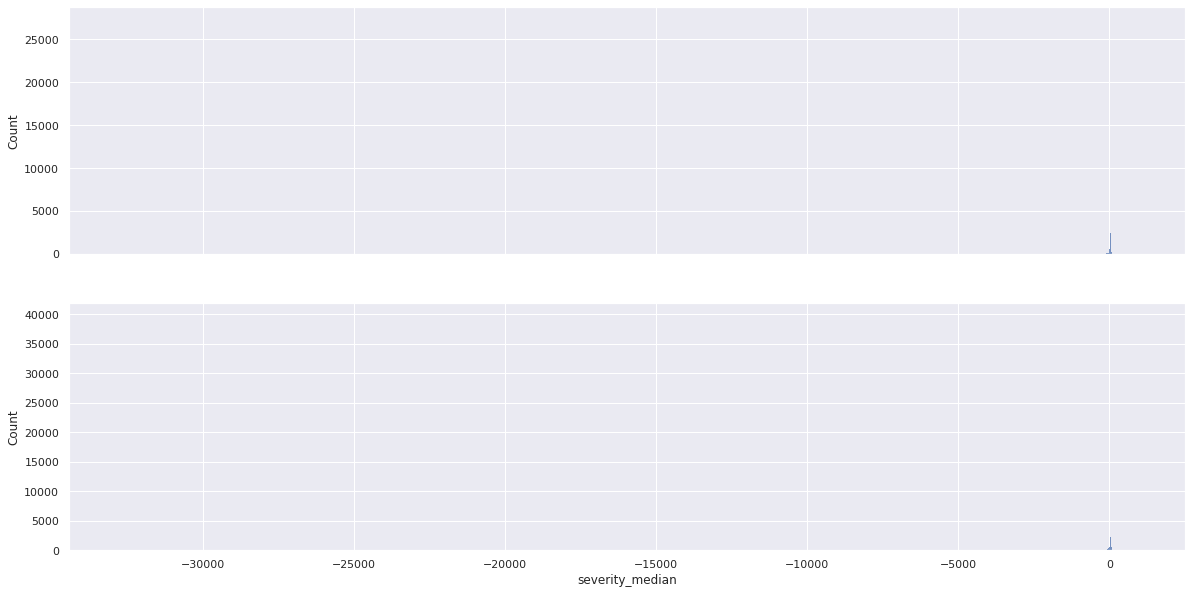

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(before_fire(gedi_buffer_dnbr), x='severity_median', ax=ax[0])
sns.histplot(after_fire(gedi_buffer_dnbr), x='severity_median', ax=ax[1])

<AxesSubplot: xlabel='severity_median', ylabel='Count'>

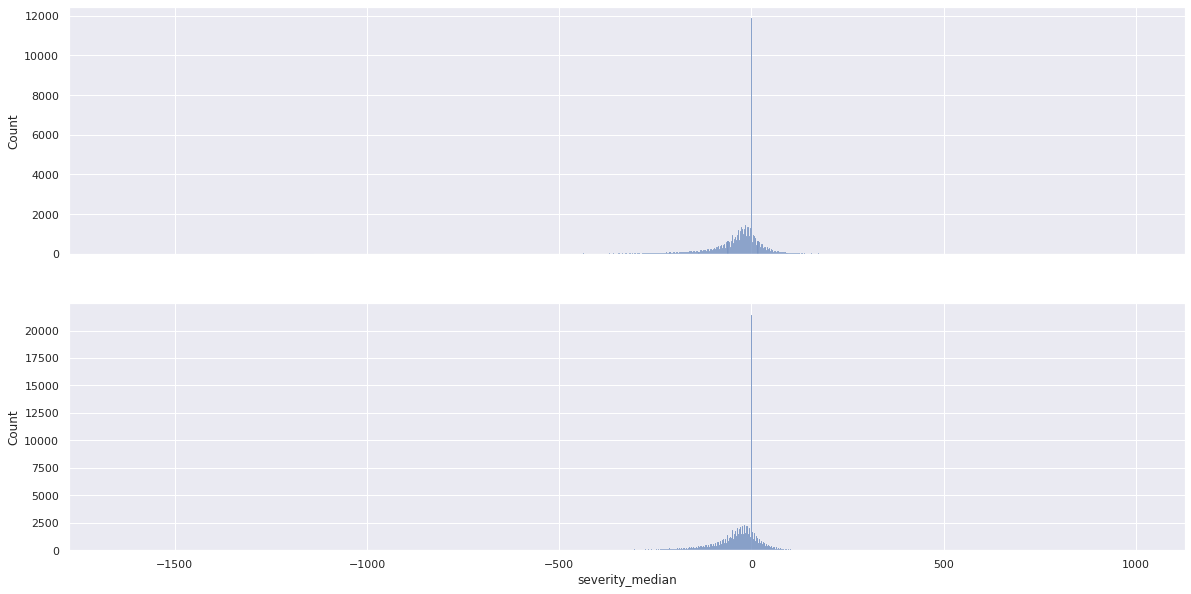

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(before_fire(gedi_buffer_rdnbr), x='severity_median', ax=ax[0])
sns.histplot(after_fire(gedi_buffer_rdnbr), x='severity_median', ax=ax[1])

<AxesSubplot: xlabel='severity_median', ylabel='Count'>

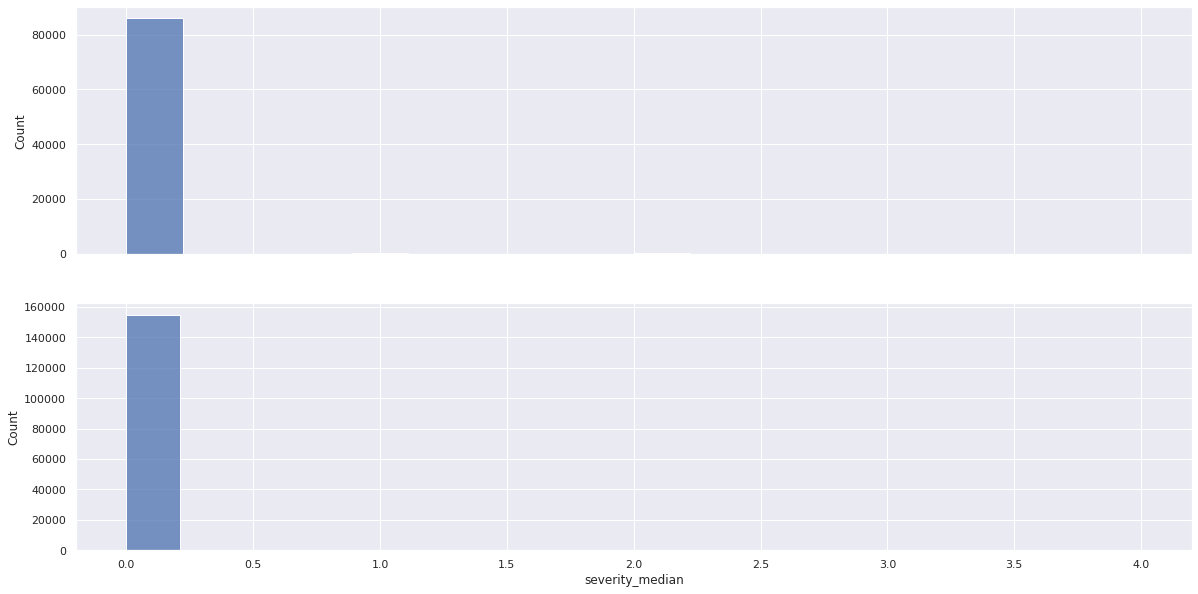

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(before_fire(gedi_buffer_dnbr6), x='severity_median', ax=ax[0])
sns.histplot(after_fire(gedi_buffer_dnbr6), x='severity_median', ax=ax[1])

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot: >

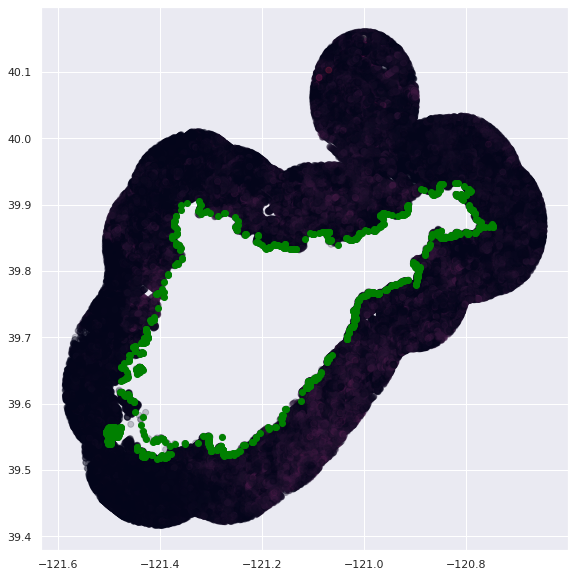

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

gedi_buffer_dnbr.plot(column='agbd', ax=ax, alpha=0.2)
gedi_buffer_dnbr6[gedi_buffer_dnbr6.severity_median != 0].plot(column='agbd', ax=ax, color='green')

Interesting, so all the shots in the outer region that have burn severity != 0 are around the fire perimeter. Which means when we're looking for counter-factual, we should focus on those pixels with burn severity of 0.

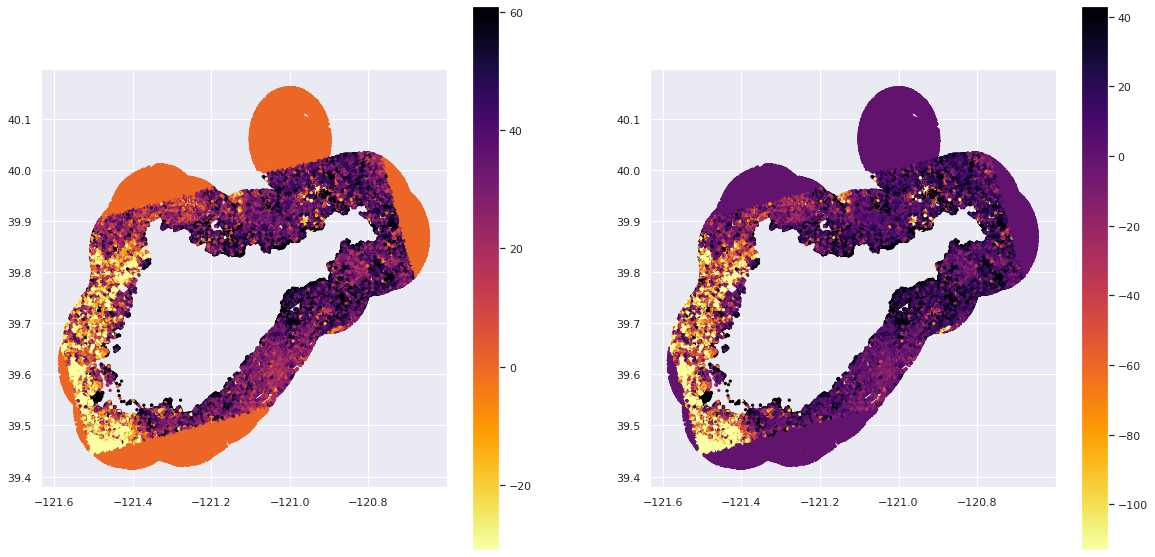

In [47]:

fig, ax = plt.subplots(1, 2, figsize=(20,10))

geo_plot(gedi_buffer_dnbr, ax[0], 'severity_mean')
geo_plot(gedi_buffer_rdnbr, ax[1], 'severity_mean')

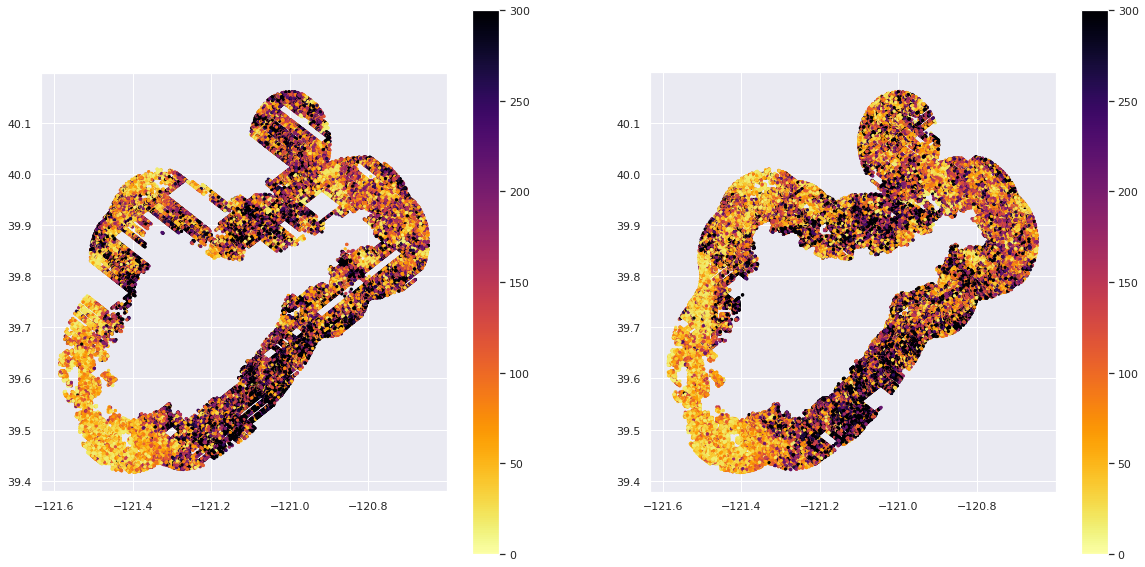

In [48]:

fig, ax = plt.subplots(1, 2, figsize=(20,10))

geo_plot(unburned_before[unburned_before.pft_class==1], ax=ax[0], vmin=0, vmax=300)
geo_plot(unburned_after[unburned_after.pft_class==1], ax=ax[1], vmin=0, vmax=300)

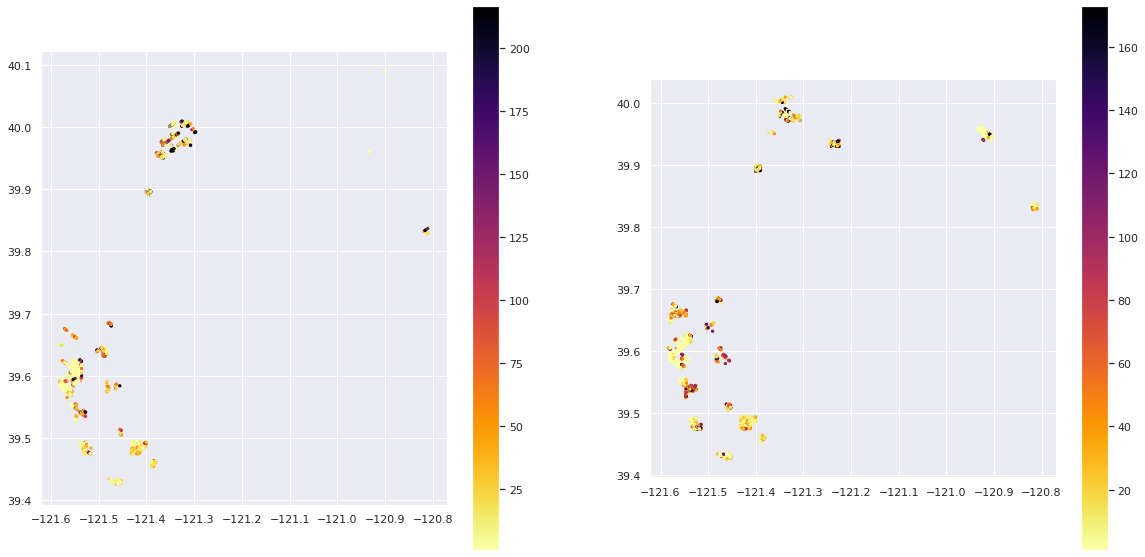

In [49]:

fig, ax = plt.subplots(1, 2, figsize=(20,10))

geo_plot(unburned_before[unburned_before.pft_class==6], ax=ax[0])
geo_plot(unburned_after[unburned_after.pft_class==6], ax=ax[1])

In [50]:
# Divide unburned after into two segments
unburned_after.absolute_time = pd.to_datetime(unburned_after.absolute_time, utc=True)
unburned_after_1 = unburned_after[unburned_after.absolute_time < '01-01-2022']
unburned_after_2 = unburned_after[unburned_after.absolute_time > '01-01-2022']

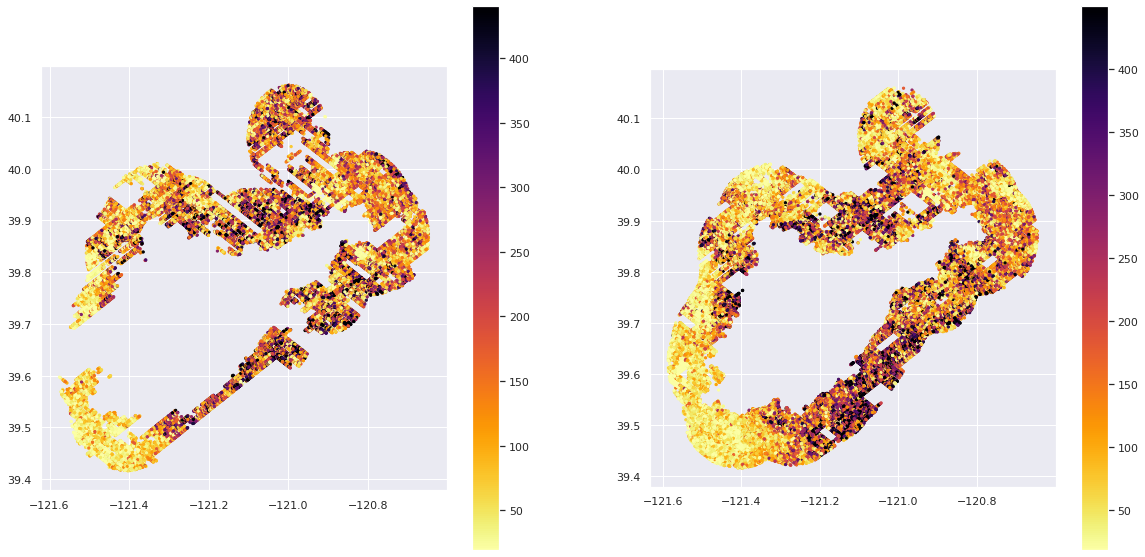

In [53]:

fig, ax = plt.subplots(1, 2, figsize=(20,10))

geo_plot(unburned_after_1, ax=ax[0])
geo_plot(unburned_after_2, ax=ax[1])

In [54]:
print('AGBD before fire')
print(unburned_after_1.agbd.describe())

print('AGBD after fire')
print(unburned_after_2.agbd.describe())

AGBD before fire
count    52759.000000
mean       158.086309
std        138.462445
min          0.834731
25%         52.315100
50%        116.549217
75%        222.026756
max       1129.367920
Name: agbd, dtype: float64
AGBD after fire
count    100913.000000
mean        152.630909
std         145.163429
min           0.834731
25%          44.745190
50%         104.965851
75%         214.147415
max        3538.607178
Name: agbd, dtype: float64


In [55]:
gedi_dnbr.corr()

/tmp/ipykernel_340330/608907356.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  gedi_dnbr.corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000        0.119632        0.063541 -0.275637   
lon_lowestmode      0.119632        1.000000        0.597337  0.045839   
lat_lowestmode      0.063541        0.597337        1.000000  0.153550   
agbd               -0.275637        0.045839        0.153550  1.000000   
agbd_pi_lower      -0.244944        0.009385        0.138217  0.443755   
agbd_pi_upper      -0.287706        0.047224        0.162635  0.997473   
agbd_se             0.003739        0.064374        0.100852  0.052763   
sensitivity        -0.331718       -0.073046       -0.016196  0.287161   
pft_class          -0.007935       -0.072731       -0.095537 -0.026816   
severity_sample    -0.093489       -0.140158       -0.186506 -0.166602   
severity_mean      -0.097483       -0.147413       -0.196391 -0.168055   
severity_std        0.023366        0.077034        0.021369 -0.114170   
severity_median    -0.097054       -0.149632       -0.199072 -0.169874   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number          -0.244944      -0.287706  0.003739    -0.331718   
lon_lowestmode        0.009385       0.047224  0.064374    -0.073046   
lat_lowestmode        0.138217       0.162635  0.100852    -0.016196   
agbd                  0.443755       0.997473  0.052763     0.287161   
agbd_pi_lower         1.000000       0.484302  0.000827     0.240282   
agbd_pi_upper         0.484302       1.000000  0.070785     0.298883   
agbd_se               0.000827       0.070785  1.000000     0.054540   
sensitivity           0.240282       0.298883  0.054540     1.000000   
pft_class             0.013347      -0.044280 -0.954191    -0.041225   
severity_sample      -0.142316      -0.172367  0.064655     0.007039   
severity_mean        -0.152591      -0.174458  0.069786     0.005590   
severity_std         -0.078808      -0.116010  0.020325    -0.054582   
severity_median      -0.151292      -0.176189  0.067743     0.005808   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number      -0.007935        -0.093489      -0.097483      0.023366   
lon_lowestmode   -0.072731        -0.140158      -0.147413      0.077034   
lat_lowestmode   -0.095537        -0.186506      -0.196391      0.021369   
agbd             -0.026816        -0.166602      -0.168055     -0.114170   
agbd_pi_lower     0.013347        -0.142316      -0.152591     -0.078808   
agbd_pi_upper    -0.044280        -0.172367      -0.174458     -0.116010   
agbd_se          -0.954191         0.064655       0.069786      0.020325   
sensitivity      -0.041225         0.007039       0.005590     -0.054582   
pft_class         1.000000        -0.058770      -0.063504     -0.018537   
severity_sample  -0.058770         1.000000       0.967672     -0.026259   
severity_mean    -0.063504         0.967672       1.000000     -0.025835   
severity_std     -0.018537        -0.026259      -0.025835      1.000000   
severity_median  -0.061671         0.969891       0.993465     -0.023256   

                 severity_median  
shot_number            -0.097054  
lon_lowestmode         -0.149632  
lat_lowestmode         -0.199072  
agbd                   -0.169874  
agbd_pi_lower          -0.151292  
agbd_pi_upper          -0.176189  
agbd_se                 0.067743  
sensitivity             0.005808  
pft_class              -0.061671  
severity_sample         0.969891  
severity_mean           0.993465  
severity_std           -0.023256  
severity_median         1.000000

In [56]:
before_fire(gedi_dnbr).corr()

/tmp/ipykernel_340330/795121377.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  before_fire(gedi_dnbr).corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000        0.059916        0.250539 -0.018730   
lon_lowestmode      0.059916        1.000000        0.502014  0.027231   
lat_lowestmode      0.250539        0.502014        1.000000  0.128677   
agbd               -0.018730        0.027231        0.128677  1.000000   
agbd_pi_lower       0.003628        0.009173        0.087349  0.357074   
agbd_pi_upper      -0.017853        0.028577        0.135441  0.997850   
agbd_se            -0.018887        0.065633        0.113026  0.070646   
sensitivity         0.022071       -0.048322        0.004769  0.204153   
pft_class           0.022513       -0.073752       -0.106072 -0.043322   
severity_sample    -0.098706       -0.071936       -0.098303  0.137468   
severity_mean      -0.106486       -0.077453       -0.103150  0.139553   
severity_std       -0.001857        0.067348       -0.007793 -0.152759   
severity_median    -0.105508       -0.079709       -0.107199  0.137151   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number           0.003628      -0.017853 -0.018887     0.022071   
lon_lowestmode        0.009173       0.028577  0.065633    -0.048322   
lat_lowestmode        0.087349       0.135441  0.113026     0.004769   
agbd                  0.357074       0.997850  0.070646     0.204153   
agbd_pi_lower         1.000000       0.389375  0.016261     0.180492   
agbd_pi_upper         0.389375       1.000000  0.093070     0.213612   
agbd_se               0.016261       0.093070  1.000000     0.083551   
sensitivity           0.180492       0.213612  0.083551     1.000000   
pft_class            -0.004436      -0.065229 -0.951198    -0.066154   
severity_sample       0.128417       0.145304  0.083514     0.102143   
severity_mean         0.117950       0.146788  0.089386     0.101686   
severity_std         -0.101084      -0.155750  0.015451    -0.064051   
severity_median       0.121569       0.144541  0.087206     0.101252   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number       0.022513        -0.098706      -0.106486     -0.001857   
lon_lowestmode   -0.073752        -0.071936      -0.077453      0.067348   
lat_lowestmode   -0.106072        -0.098303      -0.103150     -0.007793   
agbd             -0.043322         0.137468       0.139553     -0.152759   
agbd_pi_lower    -0.004436         0.128417       0.117950     -0.101084   
agbd_pi_upper    -0.065229         0.145304       0.146788     -0.155750   
agbd_se          -0.951198         0.083514       0.089386      0.015451   
sensitivity      -0.066154         0.102143       0.101686     -0.064051   
pft_class         1.000000        -0.074276      -0.079646     -0.014446   
severity_sample  -0.074276         1.000000       0.968029     -0.100747   
severity_mean    -0.079646         0.968029       1.000000     -0.106815   
severity_std     -0.014446        -0.100747      -0.106815      1.000000   
severity_median  -0.077516         0.970103       0.993560     -0.098151   

                 severity_median  
shot_number            -0.105508  
lon_lowestmode         -0.079709  
lat_lowestmode         -0.107199  
agbd                    0.137151  
agbd_pi_lower           0.121569  
agbd_pi_upper           0.144541  
agbd_se                 0.087206  
sensitivity             0.101252  
pft_class              -0.077516  
severity_sample         0.970103  
severity_mean           0.993560  
severity_std           -0.098151  
severity_median         1.000000

In [57]:
before_fire(gedi_rdnbr).corr()

/tmp/ipykernel_340330/2486856634.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  before_fire(gedi_rdnbr).corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000        0.059916        0.250539 -0.018730   
lon_lowestmode      0.059916        1.000000        0.502014  0.027231   
lat_lowestmode      0.250539        0.502014        1.000000  0.128677   
agbd               -0.018730        0.027231        0.128677  1.000000   
agbd_pi_lower       0.003628        0.009173        0.087349  0.357074   
agbd_pi_upper      -0.017853        0.028577        0.135441  0.997850   
agbd_se            -0.018887        0.065633        0.113026  0.070646   
sensitivity         0.022071       -0.048322        0.004769  0.204153   
pft_class           0.022513       -0.073752       -0.106072 -0.043322   
severity_sample    -0.090675       -0.070846       -0.121345  0.051906   
severity_mean      -0.097420       -0.074899       -0.127237  0.054040   
severity_std        0.019248        0.038142        0.008885 -0.145424   
severity_median    -0.097058       -0.077882       -0.132820  0.051719   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number           0.003628      -0.017853 -0.018887     0.022071   
lon_lowestmode        0.009173       0.028577  0.065633    -0.048322   
lat_lowestmode        0.087349       0.135441  0.113026     0.004769   
agbd                  0.357074       0.997850  0.070646     0.204153   
agbd_pi_lower         1.000000       0.389375  0.016261     0.180492   
agbd_pi_upper         0.389375       1.000000  0.093070     0.213612   
agbd_se               0.016261       0.093070  1.000000     0.083551   
sensitivity           0.180492       0.213612  0.083551     1.000000   
pft_class            -0.004436      -0.065229 -0.951198    -0.066154   
severity_sample       0.053730       0.056079  0.082285     0.067978   
severity_mean         0.044956       0.057747  0.088260     0.067157   
severity_std         -0.105140      -0.149734 -0.016007    -0.074920   
severity_median       0.044744       0.055417  0.085816     0.066424   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number       0.022513        -0.090675      -0.097420      0.019248   
lon_lowestmode   -0.073752        -0.070846      -0.074899      0.038142   
lat_lowestmode   -0.106072        -0.121345      -0.127237      0.008885   
agbd             -0.043322         0.051906       0.054040     -0.145424   
agbd_pi_lower    -0.004436         0.053730       0.044956     -0.105140   
agbd_pi_upper    -0.065229         0.056079       0.057747     -0.149734   
agbd_se          -0.951198         0.082285       0.088260     -0.016007   
sensitivity      -0.066154         0.067978       0.067157     -0.074920   
pft_class         1.000000        -0.073461      -0.079332      0.014682   
severity_sample  -0.073461         1.000000       0.964134     -0.199445   
severity_mean    -0.079332         0.964134       1.000000     -0.218341   
severity_std      0.014682        -0.199445      -0.218341      1.000000   
severity_median  -0.076765         0.965455       0.993112     -0.216966   

                 severity_median  
shot_number            -0.097058  
lon_lowestmode         -0.077882  
lat_lowestmode         -0.132820  
agbd                    0.051719  
agbd_pi_lower           0.044744  
agbd_pi_upper           0.055417  
agbd_se                 0.085816  
sensitivity             0.066424  
pft_class              -0.076765  
severity_sample         0.965455  
severity_mean           0.993112  
severity_std           -0.216966  
severity_median         1.000000

In [58]:
after_fire(gedi_dnbr).corr()

/tmp/ipykernel_340330/861096128.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  after_fire(gedi_dnbr).corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000       -0.031119       -0.117009 -0.131136   
lon_lowestmode     -0.031119        1.000000        0.612892  0.123938   
lat_lowestmode     -0.117009        0.612892        1.000000  0.221418   
agbd               -0.131136        0.123938        0.221418  1.000000   
agbd_pi_lower      -0.123144        0.045475        0.183769  0.458356   
agbd_pi_upper      -0.138000        0.126252        0.232890  0.997191   
agbd_se            -0.014596        0.062929        0.094308  0.047645   
sensitivity        -0.032339        0.003895        0.033406  0.223698   
pft_class           0.012347       -0.070819       -0.088837 -0.023249   
severity_sample     0.061402       -0.127759       -0.202402 -0.431533   
severity_mean       0.063263       -0.133773       -0.213592 -0.438464   
severity_std        0.024553        0.081124        0.034466 -0.090630   
severity_median     0.063076       -0.136346       -0.215867 -0.439445   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number          -0.123144      -0.138000 -0.014596    -0.032339   
lon_lowestmode        0.045475       0.126252  0.062929     0.003895   
lat_lowestmode        0.183769       0.232890  0.094308     0.033406   
agbd                  0.458356       0.997191  0.047645     0.223698   
agbd_pi_lower         1.000000       0.502596 -0.001938     0.180646   
agbd_pi_upper         0.502596       1.000000  0.064798     0.232562   
agbd_se              -0.001938       0.064798  1.000000     0.054305   
sensitivity           0.180646       0.232562  0.054305     1.000000   
pft_class             0.017700      -0.039579 -0.957366    -0.044542   
severity_sample      -0.276868      -0.441427  0.057722    -0.110870   
severity_mean        -0.289571      -0.449048  0.062761    -0.116412   
severity_std         -0.072372      -0.092764  0.023868    -0.048006   
severity_median      -0.288549      -0.449978  0.060746    -0.115423   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number       0.012347         0.061402       0.063263      0.024553   
lon_lowestmode   -0.070819        -0.127759      -0.133773      0.081124   
lat_lowestmode   -0.088837        -0.202402      -0.213592      0.034466   
agbd             -0.023249        -0.431533      -0.438464     -0.090630   
agbd_pi_lower     0.017700        -0.276868      -0.289571     -0.072372   
agbd_pi_upper    -0.039579        -0.441427      -0.449048     -0.092764   
agbd_se          -0.957366         0.057722       0.062761      0.023868   
sensitivity      -0.044542        -0.110870      -0.116412     -0.048006   
pft_class         1.000000        -0.055129      -0.059880     -0.021523   
severity_sample  -0.055129         1.000000       0.966666      0.009482   
severity_mean    -0.059880         0.966666       1.000000      0.013633   
severity_std     -0.021523         0.009482       0.013633      1.000000   
severity_median  -0.058186         0.969064       0.993232      0.013164   

                 severity_median  
shot_number             0.063076  
lon_lowestmode         -0.136346  
lat_lowestmode         -0.215867  
agbd                   -0.439445  
agbd_pi_lower          -0.288549  
agbd_pi_upper          -0.449978  
agbd_se                 0.060746  
sensitivity            -0.115423  
pft_class              -0.058186  
severity_sample         0.969064  
severity_mean           0.993232  
severity_std            0.013164  
severity_median         1.000000

In [59]:
after_fire(gedi_rdnbr).corr()

/tmp/ipykernel_340330/1135705856.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  after_fire(gedi_rdnbr).corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000       -0.031119       -0.117009 -0.131136   
lon_lowestmode     -0.031119        1.000000        0.612892  0.123938   
lat_lowestmode     -0.117009        0.612892        1.000000  0.221418   
agbd               -0.131136        0.123938        0.221418  1.000000   
agbd_pi_lower      -0.123144        0.045475        0.183769  0.458356   
agbd_pi_upper      -0.138000        0.126252        0.232890  0.997191   
agbd_se            -0.014596        0.062929        0.094308  0.047645   
sensitivity        -0.032339        0.003895        0.033406  0.223698   
pft_class           0.012347       -0.070819       -0.088837 -0.023249   
severity_sample     0.068345       -0.127095       -0.220518 -0.485626   
severity_mean       0.071432       -0.133084       -0.232921 -0.496155   
severity_std        0.014141        0.071200        0.055761 -0.033541   
severity_median     0.071785       -0.137675       -0.238142 -0.500411   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number          -0.123144      -0.138000 -0.014596    -0.032339   
lon_lowestmode        0.045475       0.126252  0.062929     0.003895   
lat_lowestmode        0.183769       0.232890  0.094308     0.033406   
agbd                  0.458356       0.997191  0.047645     0.223698   
agbd_pi_lower         1.000000       0.502596 -0.001938     0.180646   
agbd_pi_upper         0.502596       1.000000  0.064798     0.232562   
agbd_se              -0.001938       0.064798  1.000000     0.054305   
sensitivity           0.180646       0.232562  0.054305     1.000000   
pft_class             0.017700      -0.039579 -0.957366    -0.044542   
severity_sample      -0.337409      -0.498407  0.055789    -0.129576   
severity_mean        -0.351527      -0.509613  0.061500    -0.136178   
severity_std         -0.007726      -0.032563 -0.003330    -0.018424   
severity_median      -0.352126      -0.513884  0.059325    -0.136448   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number       0.012347         0.068345       0.071432      0.014141   
lon_lowestmode   -0.070819        -0.127095      -0.133084      0.071200   
lat_lowestmode   -0.088837        -0.220518      -0.232921      0.055761   
agbd             -0.023249        -0.485626      -0.496155     -0.033541   
agbd_pi_lower     0.017700        -0.337409      -0.351527     -0.007726   
agbd_pi_upper    -0.039579        -0.498407      -0.509613     -0.032563   
agbd_se          -0.957366         0.055789       0.061500     -0.003330   
sensitivity      -0.044542        -0.129576      -0.136178     -0.018424   
pft_class         1.000000        -0.055119      -0.060729      0.003834   
severity_sample  -0.055119         1.000000       0.957266     -0.064699   
severity_mean    -0.060729         0.957266       1.000000     -0.077134   
severity_std      0.003834        -0.064699      -0.077134      1.000000   
severity_median  -0.058718         0.957611       0.991599     -0.100379   

                 severity_median  
shot_number             0.071785  
lon_lowestmode         -0.137675  
lat_lowestmode         -0.238142  
agbd                   -0.500411  
agbd_pi_lower          -0.352126  
agbd_pi_upper          -0.513884  
agbd_se                 0.059325  
sensitivity            -0.136448  
pft_class              -0.058718  
severity_sample         0.957611  
severity_mean           0.991599  
severity_std           -0.100379  
severity_median         1.000000

In [72]:
gedi_dnbr6_perfect = gedi_dnbr6[gedi_dnbr6.severity_std == 0]

In [73]:
gedi_dnbr_perfect = gedi_dnbr[gedi_dnbr6.severity_std == 0]
gedi_rdnbr_perfect = gedi_rdnbr[gedi_dnbr6.severity_std == 0]

In [79]:
after_fire(gedi_dnbr_perfect).corr()

/tmp/ipykernel_340330/1420271049.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  after_fire(gedi_dnbr_perfect).corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000        0.001135       -0.134576 -0.138805   
lon_lowestmode      0.001135        1.000000        0.578353  0.086027   
lat_lowestmode     -0.134576        0.578353        1.000000  0.220428   
agbd               -0.138805        0.086027        0.220428  1.000000   
agbd_pi_lower      -0.135431       -0.004777        0.156060  0.458703   
agbd_pi_upper      -0.146182        0.084043        0.228320  0.996874   
agbd_se            -0.021082        0.049088        0.068483  0.037546   
sensitivity        -0.025367       -0.020780        0.018263  0.212342   
pft_class           0.015808       -0.068646       -0.064265  0.002478   
severity_sample     0.091342       -0.102730       -0.226333 -0.559342   
severity_mean       0.091112       -0.105807       -0.230669 -0.562823   
severity_std        0.050405        0.118397        0.051768 -0.158157   
severity_median     0.091236       -0.105394       -0.230516 -0.563152   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number          -0.135431      -0.146182 -0.021082    -0.025367   
lon_lowestmode       -0.004777       0.084043  0.049088    -0.020780   
lat_lowestmode        0.156060       0.228320  0.068483     0.018263   
agbd                  0.458703       0.996874  0.037546     0.212342   
agbd_pi_lower         1.000000       0.507086 -0.008900     0.169211   
agbd_pi_upper         0.507086       1.000000  0.049715     0.220937   
agbd_se              -0.008900       0.049715  1.000000     0.036087   
sensitivity           0.169211       0.220937  0.036087     1.000000   
pft_class             0.034500      -0.008406 -0.957793    -0.021875   
severity_sample      -0.300040      -0.568220  0.058765    -0.130250   
severity_mean        -0.302422      -0.571821  0.057345    -0.132046   
severity_std         -0.094587      -0.161355  0.024039    -0.062627   
severity_median      -0.303021      -0.572206  0.057015    -0.131230   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number       0.015808         0.091342       0.091112      0.050405   
lon_lowestmode   -0.068646        -0.102730      -0.105807      0.118397   
lat_lowestmode   -0.064265        -0.226333      -0.230669      0.051768   
agbd              0.002478        -0.559342      -0.562823     -0.158157   
agbd_pi_lower     0.034500        -0.300040      -0.302422     -0.094587   
agbd_pi_upper    -0.008406        -0.568220      -0.571821     -0.161355   
agbd_se          -0.957793         0.058765       0.057345      0.024039   
sensitivity      -0.021875        -0.130250      -0.132046     -0.062627   
pft_class         1.000000        -0.062476      -0.060768     -0.024841   
severity_sample  -0.062476         1.000000       0.987931      0.264732   
severity_mean    -0.060768         0.987931       1.000000      0.259800   
severity_std     -0.024841         0.264732       0.259800      1.000000   
severity_median  -0.060545         0.988274       0.998202      0.267335   

                 severity_median  
shot_number             0.091236  
lon_lowestmode         -0.105394  
lat_lowestmode         -0.230516  
agbd                   -0.563152  
agbd_pi_lower          -0.303021  
agbd_pi_upper          -0.572206  
agbd_se                 0.057015  
sensitivity            -0.131230  
pft_class              -0.060545  
severity_sample         0.988274  
severity_mean           0.998202  
severity_std            0.267335  
severity_median         1.000000

In [80]:
after_fire(gedi_rdnbr_perfect).corr()

/tmp/ipykernel_340330/400803325.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  after_fire(gedi_rdnbr_perfect).corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000        0.001135       -0.134576 -0.138805   
lon_lowestmode      0.001135        1.000000        0.578353  0.086027   
lat_lowestmode     -0.134576        0.578353        1.000000  0.220428   
agbd               -0.138805        0.086027        0.220428  1.000000   
agbd_pi_lower      -0.135431       -0.004777        0.156060  0.458703   
agbd_pi_upper      -0.146182        0.084043        0.228320  0.996874   
agbd_se            -0.021082        0.049088        0.068483  0.037546   
sensitivity        -0.025367       -0.020780        0.018263  0.212342   
pft_class           0.015808       -0.068646       -0.064265  0.002478   
severity_sample     0.091500       -0.092527       -0.228841 -0.588410   
severity_mean       0.093747       -0.096151       -0.234255 -0.594461   
severity_std        0.013959        0.081416        0.052058 -0.037739   
severity_median     0.094577       -0.097022       -0.234768 -0.596037   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number          -0.135431      -0.146182 -0.021082    -0.025367   
lon_lowestmode       -0.004777       0.084043  0.049088    -0.020780   
lat_lowestmode        0.156060       0.228320  0.068483     0.018263   
agbd                  0.458703       0.996874  0.037546     0.212342   
agbd_pi_lower         1.000000       0.507086 -0.008900     0.169211   
agbd_pi_upper         0.507086       1.000000  0.049715     0.220937   
agbd_se              -0.008900       0.049715  1.000000     0.036087   
sensitivity           0.169211       0.220937  0.036087     1.000000   
pft_class             0.034500      -0.008406 -0.957793    -0.021875   
severity_sample      -0.331404      -0.598717  0.062923    -0.140645   
severity_mean        -0.335238      -0.604899  0.060327    -0.143205   
severity_std         -0.021574      -0.037855 -0.014440    -0.023528   
severity_median      -0.335638      -0.606476  0.060037    -0.142743   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number       0.015808         0.091500       0.093747      0.013959   
lon_lowestmode   -0.068646        -0.092527      -0.096151      0.081416   
lat_lowestmode   -0.064265        -0.228841      -0.234255      0.052058   
agbd              0.002478        -0.588410      -0.594461     -0.037739   
agbd_pi_lower     0.034500        -0.331404      -0.335238     -0.021574   
agbd_pi_upper    -0.008406        -0.598717      -0.604899     -0.037855   
agbd_se          -0.957793         0.062923       0.060327     -0.014440   
sensitivity      -0.021875        -0.140645      -0.143205     -0.023528   
pft_class         1.000000        -0.068502      -0.065862      0.012594   
severity_sample  -0.068502         1.000000       0.982254      0.033133   
severity_mean    -0.065862         0.982254       1.000000      0.008164   
severity_std      0.012594         0.033133       0.008164      1.000000   
severity_median  -0.065640         0.981608       0.997214     -0.003916   

                 severity_median  
shot_number             0.094577  
lon_lowestmode         -0.097022  
lat_lowestmode         -0.234768  
agbd                   -0.596037  
agbd_pi_lower          -0.335638  
agbd_pi_upper          -0.606476  
agbd_se                 0.060037  
sensitivity            -0.142743  
pft_class              -0.065640  
severity_sample         0.981608  
severity_mean           0.997214  
severity_std           -0.003916  
severity_median         1.000000

### Visualize severity for combined GEDI

In [65]:
gedi_all = pd.concat([fire.gedi, fire.gedi_buffer])

In [66]:
gedi_all_dnbr = pd.concat([gedi_dnbr, gedi_buffer_dnbr])

<AxesSubplot: >

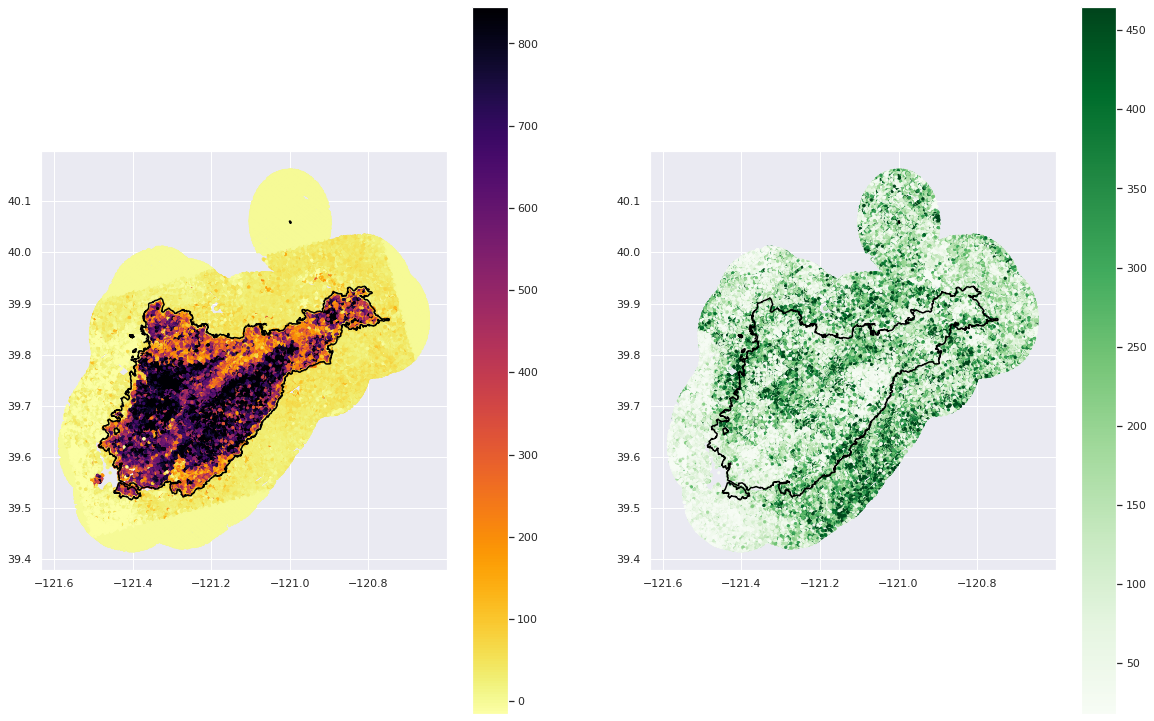

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(20, 13))

geo_plot(gedi_all_dnbr, ax[0], 'severity_mean')
gedi_viz.geo_plot(gedi_all, ax[1], 'agbd', cmap='Greens')
fire.fire.boundary.plot(ax=ax[0], color='black')
fire.fire.boundary.plot(ax=ax[1], color='black')

<AxesSubplot: >

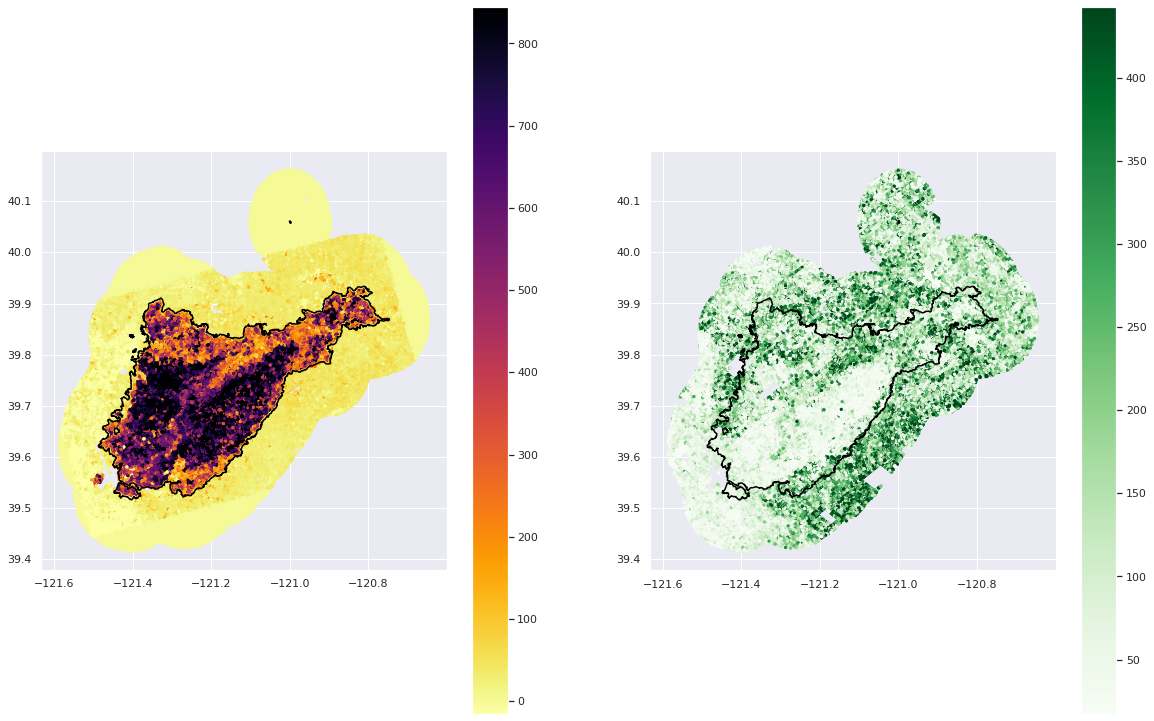

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(20, 13))

geo_plot(gedi_all_dnbr, ax[0], 'severity_mean')
gedi_viz.geo_plot(after_fire(gedi_all), ax[1], 'agbd', cmap='Greens')
fire.fire.boundary.plot(ax=ax[0], color='black')
fire.fire.boundary.plot(ax=ax[1], color='black')

<AxesSubplot: >

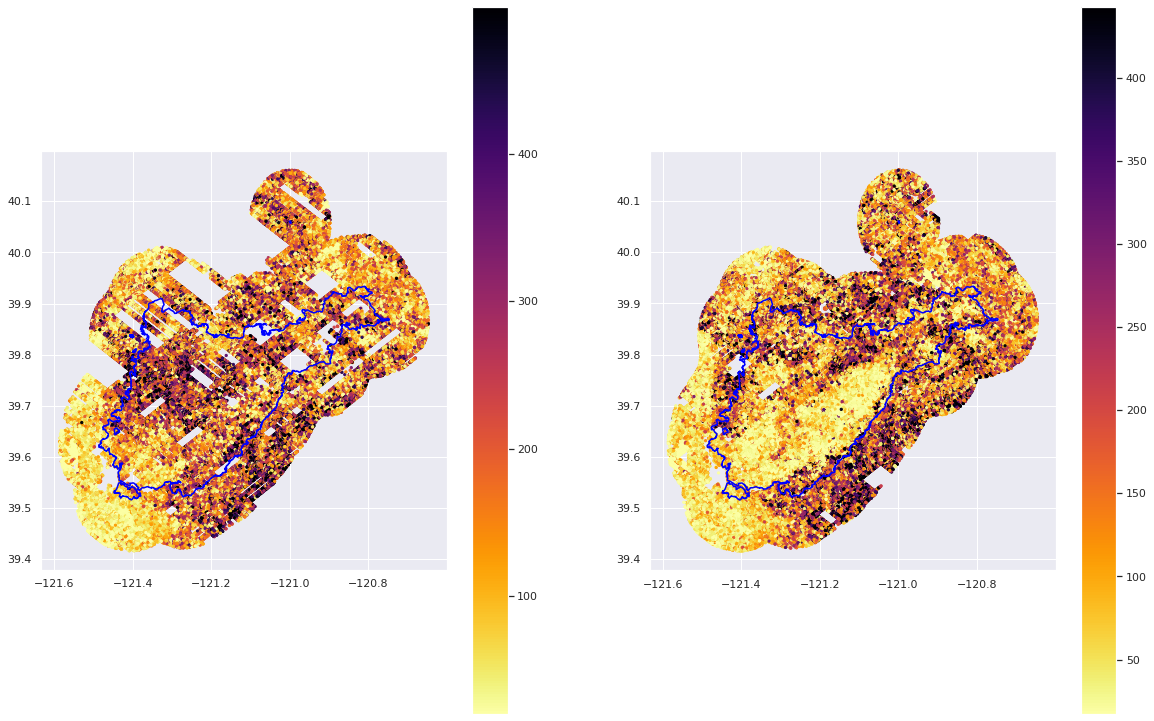

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(20, 13))

geo_plot(before_fire(gedi_all), ax[0], 'agbd')
geo_plot(after_fire(gedi_all), ax[1], 'agbd')
fire.fire.boundary.plot(ax=ax[0], color='blue')
fire.fire.boundary.plot(ax=ax[1], color='blue')